In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Load the data and set the DateTime index
df = pd.read_csv('../data/banks_data_1984.csv')
df.DATE = pd.to_datetime(df.DATE, infer_datetime_format=True)
df.set_index("DATE", inplace = True)

In [3]:
df.columns

Index(['US100NUM', 'US13NUM', 'US31NUM', 'US115NUM', 'USG15NUM', 'US100NIM',
       'US13NIM', 'US31NIM', 'US115NIM', 'USG15NIM', 'US100ROA', 'US13ROA',
       'US31ROA', 'US115ROA', 'USG15ROA', 'USNIM', 'USROA', 'USNP', 'USTAST',
       'US100ROE', 'US13ROE', 'US31ROE', 'US115ROE', 'USG15ROE', 'US100NPTL',
       'US13NPTL', 'US31NPTL', 'US115NPTL', 'USG15NPTL', 'US100LLRTL',
       'US13LLRTL', 'US31LLRTL', 'US115LLRTL', 'USG15LLRTL'],
      dtype='object')

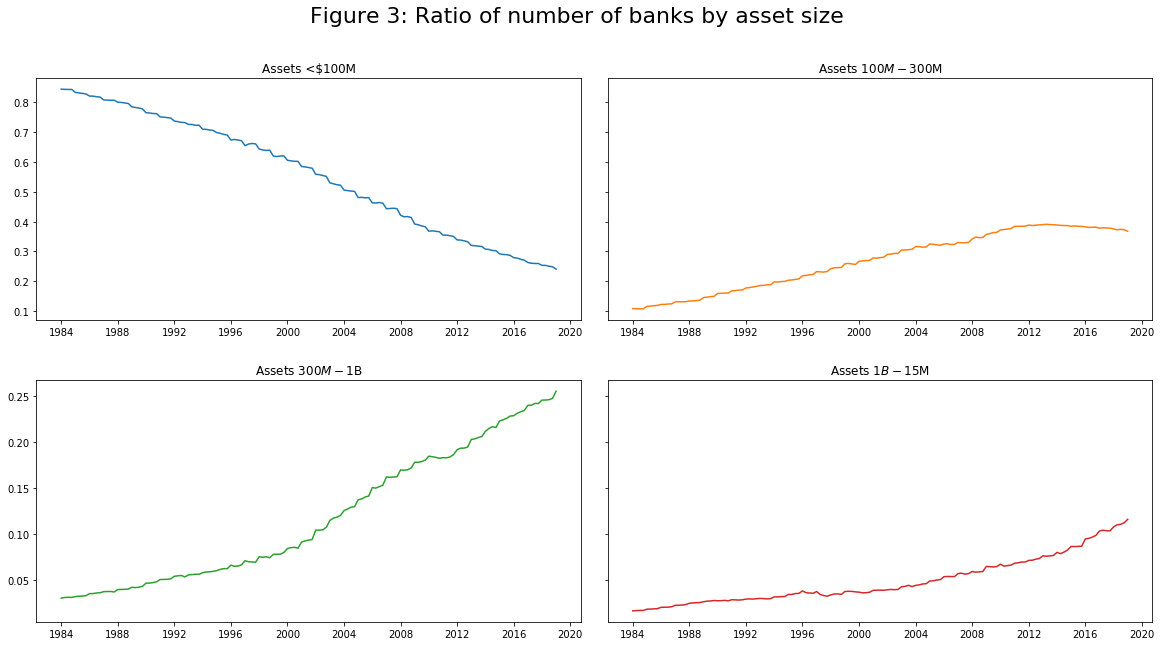

In [4]:
#Basic EDA - calc and plot relative size
#For now, we choose not to consider super big banks with assets greater than $15B
df['TinyBanksNum'] = df.US100NUM /(df.US100NUM+df.US13NUM+df.US31NUM+df.US115NUM+df.USG15NUM)
df['SmallBanksNum'] = df.US13NUM / (df.US100NUM+df.US13NUM+df.US31NUM+df.US115NUM+df.USG15NUM)
df['MidBanksNum'] = df.US31NUM / (df.US100NUM+df.US13NUM+df.US31NUM+df.US115NUM+df.USG15NUM)
df['LargeBanksNum'] = df.US115NUM /(df.US100NUM+df.US13NUM+df.US31NUM+df.US115NUM+df.USG15NUM)
df['BanksNum'] = df.US100NUM+df.US13NUM+df.US31NUM+df.US115NUM+df.USG15NUM
fig, axs = plt.subplots(2, 2, figsize = (20,10), sharey='row', gridspec_kw={'hspace': 0.25, 'wspace': 0.05})
fig.suptitle('Figure 3: Ratio of number of banks by asset size', fontsize = 22)
axs[0, 0].plot(df.TinyBanksNum)
axs[0, 0].set_title('Assets <$100M')
axs[0, 1].plot(df.SmallBanksNum, 'tab:orange')
axs[0, 1].set_title('Assets $100M-$300M')
axs[1, 0].plot(df.MidBanksNum, 'tab:green')
axs[1, 0].set_title('Assets $300M-$1B')
axs[1, 1].plot(df.LargeBanksNum, 'tab:red')
axs[1, 1].set_title('Assets $1B-$15M')
plt.show()

# Time series analysis

### Function to check for Stationarity

In [5]:
def stationarity_check(TS, window = 4):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = window, center = False).mean()
    rolstd = TS.rolling(window = window, center = False).std()
   
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

### Checking Stationarity of Net Income (of all banks) over timeline

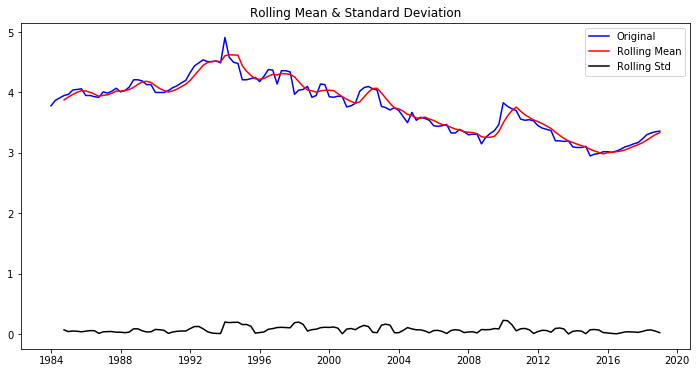

Results of Dickey-Fuller Test:
Test Statistic                  -1.171624
p-value                          0.685682
#Lags Used                       0.000000
Number of Observations Used    140.000000
Critical Value (1%)             -3.477945
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
dtype: float64


In [7]:
stationarity_check(df.USNIM)

### Result indicates Non-Stationarity

When applying the Dicky-Fuller test, the resulting test statistic does not fall below any of the calculated critical values. Thus, we fail to reject the null hypothesis that the data is non-stationary. 

To stationarize this data, we will use the differencing method. Before doing so, we'll look for any Autocorrelation and Partial Autocorrelation.



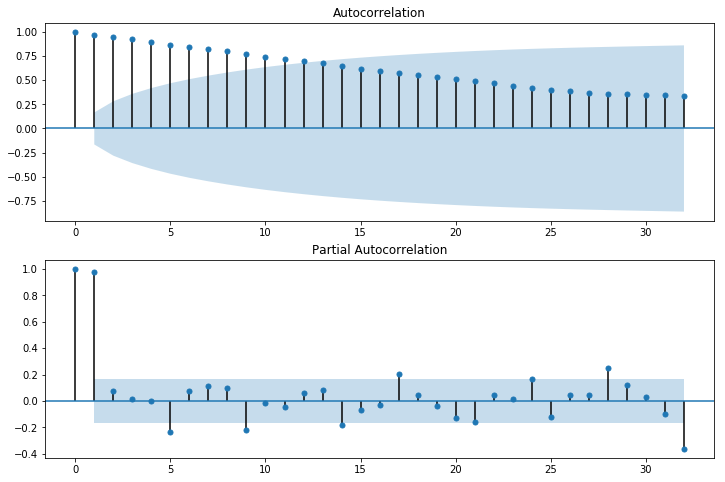

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(df.USNIM.iloc[1:], lags=32, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(df.USNIM.iloc[1:], lags=32, ax=ax2)

The partial autocorrelation plot shows us that at a lag of 5, there appears to be some statistically significant correlation. Given that this is quarterly data, we'll instead look at a shift of 4 (i.e. comparing Q1s from one year to another, Q2s to one another, etc.)

The Stationarity Check below supports the use of lag 4 for differencing the data. 

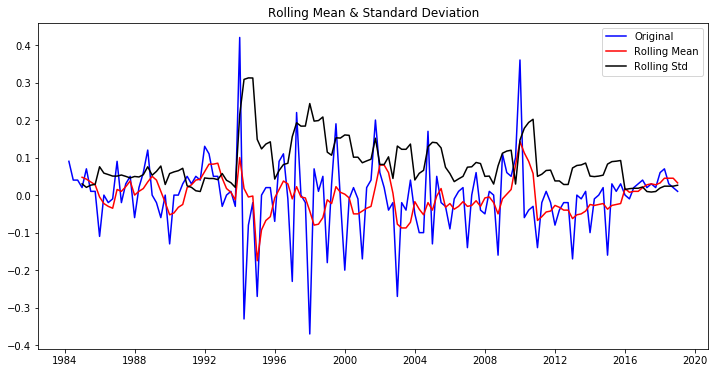

Results of Dickey-Fuller Test:
Test Statistic                -1.271777e+01
p-value                        9.978471e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.390000e+02
Critical Value (1%)           -3.478294e+00
Critical Value (5%)           -2.882568e+00
Critical Value (10%)          -2.577983e+00
dtype: float64


In [28]:
df['first_difference'] = df.USNIM - df.USNIM.shift(4)  
stationarity_check(df.first_difference.dropna(inplace=False))

Verifying that the differenced data lacks seasonality by performing a Seasonal Decomposition.

<Figure size 432x288 with 0 Axes>

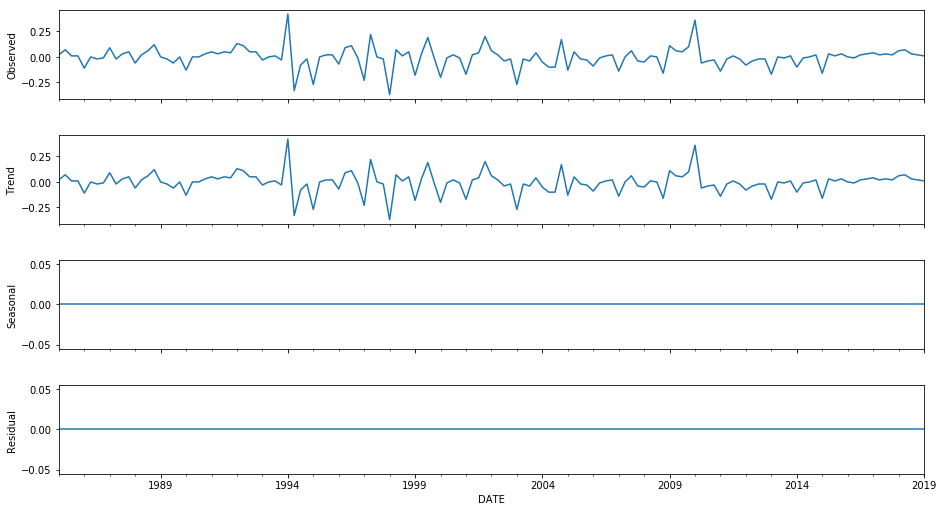

In [29]:
decomposition = seasonal_decompose(df.first_difference.iloc[4:], freq=1)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)
fig.show();

## Seasonal Decomposition Analysis:

To observe the trend in Net Income for Tiny, Small and Large Banks, we perform a seasonal decomposition on the original data for each subset using a period of 4. 

### All Banks Net Income

<Figure size 432x288 with 0 Axes>

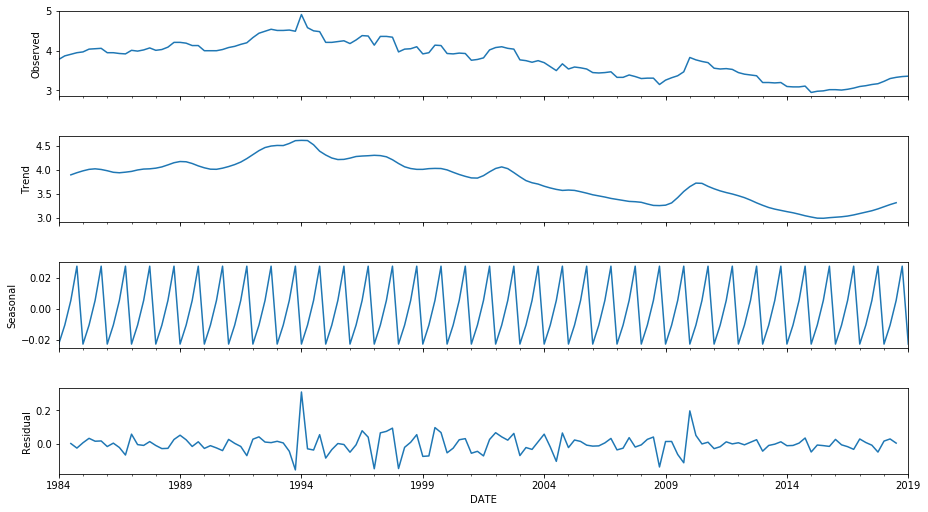

In [31]:
decomposition2 = seasonal_decompose(df.USNIM, freq=4)
fig = plt.figure()
fig = decomposition2.plot()
fig.set_size_inches(15, 8)

### Tiny Banks Net Income

<Figure size 432x288 with 0 Axes>

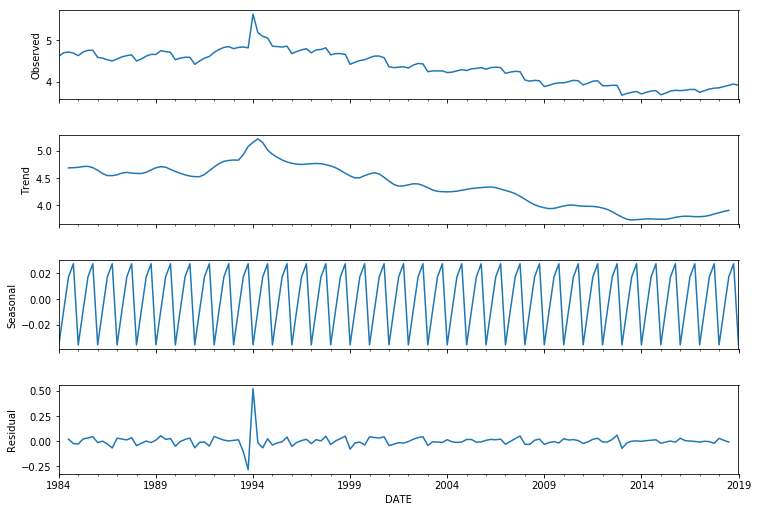

In [17]:
decomposition3 = seasonal_decompose(df.US100NIM, freq=4)
fig = plt.figure()
fig = decomposition3.plot()
fig.set_size_inches(12, 8)
fig.show()

### Small Banks Net Income

<Figure size 432x288 with 0 Axes>

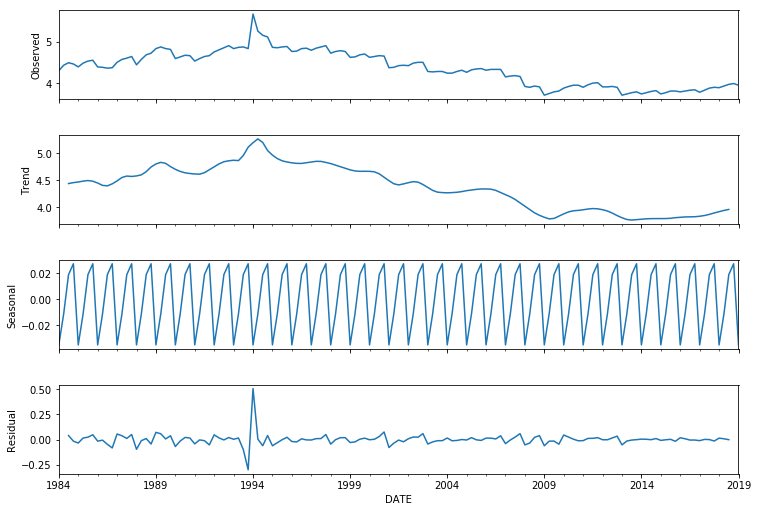

In [16]:
decomposition4 = seasonal_decompose(df.US13NIM, freq=4)
fig = plt.figure()
fig = decomposition4.plot()
fig.set_size_inches(12, 8)
fig.show()

### Large Banks Net Income

<Figure size 432x288 with 0 Axes>

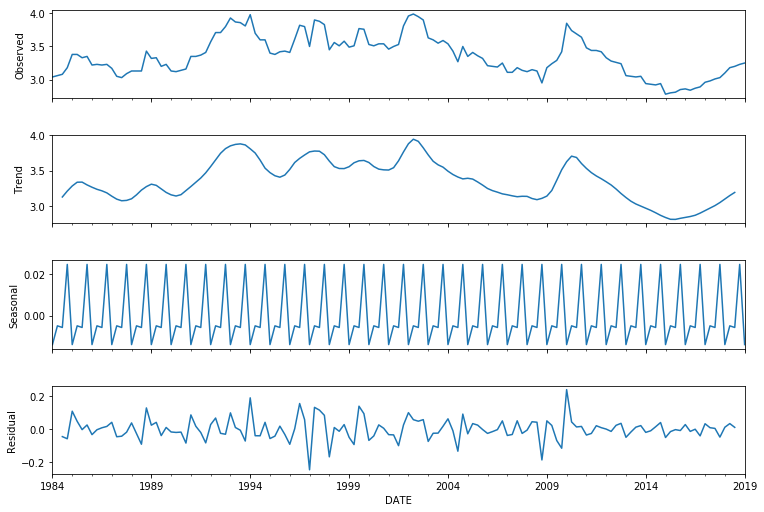

In [18]:
decomposition5 = seasonal_decompose(df.USG15NIM, freq=4)
fig = plt.figure()
fig = decomposition5.plot()
fig.set_size_inches(12, 8)
fig.show()

## Summary of Time Series Findings

With Net Income identified as a strong indicator of market health, we wanted to observe any trend in this parameter without any seasonality affects. Our series of seasonal decompositions showed that Small banks are on trend with Tiny Banks, which may suggest they are headed for a similar fate (reduced share of the market)

# Explore if Number of banks can be predicted by Net Income (NI)

In [8]:
#Consider regression NUM = b_0+b_1 * (NI)
mod = sm.OLS(df.BanksNum, sm.add_constant(df.USNIM))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               BanksNum   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     153.4
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           3.31e-24
Time:                        18:28:02   Log-Likelihood:                -1273.4
No. Observations:                 141   AIC:                             2551.
Df Residuals:                     139   BIC:                             2557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9047.0984   1460.536     -6.194      0.0

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


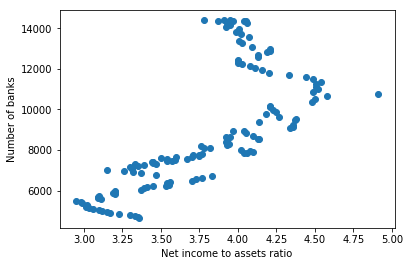

In [27]:
#Liearity check
plt.scatter(x = df.USNIM, y = df.BanksNum)
plt.ylabel('Number of banks')
plt.xlabel('Net income to assets ratio')
plt.show()

## Findings: not clear, possible issues with Durbin-Watson, need to split the sample

In [10]:
#Re-run the basic model for the first 24 qaurters - start of the period 
y_start = df.BanksNum.iloc[0:24]
x_start = df.USNIM.iloc[0:24]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               BanksNum   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     39.45
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           2.54e-06
Time:                        18:30:16   Log-Likelihood:                -176.18
No. Observations:                  24   AIC:                             356.4
Df Residuals:                      22   BIC:                             358.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.291e+04   3048.333     10.795      0.0

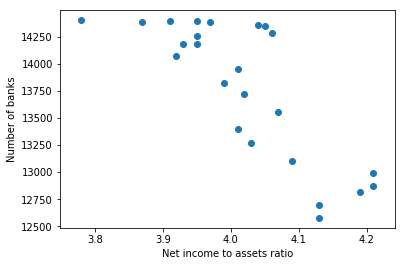

In [17]:
#Check scatter plot for linearity
plt.scatter(y=y_start, x=x_start)
plt.ylabel('Number of banks')
plt.xlabel('Net income to assets ratio')
plt.show()

In [12]:
#Re-run model for last 24 qaurters - end of the period
y_end = df.BanksNum.iloc[117:141]
x_end = df.USNIM.iloc[117:141]
mod = sm.OLS(y_end, sm.add_constant(x_end))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               BanksNum   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     5.591
Date:                Wed, 31 Jul 2019   Prob (F-statistic):             0.0273
Time:                        18:30:57   Log-Likelihood:                -174.48
No. Observations:                  24   AIC:                             353.0
Df Residuals:                      22   BIC:                             355.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9943.1402   1983.184      5.014      0.0

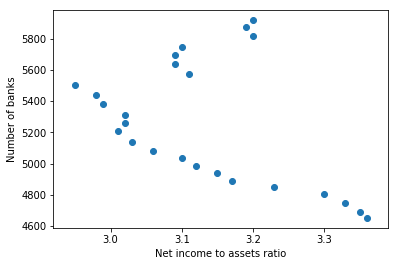

In [18]:
#Check scatter plot for linearity
plt.scatter(x=x_end, y=y_end )
plt.ylabel('Number of banks')
plt.xlabel('Net income to assets ratio')
plt.show()

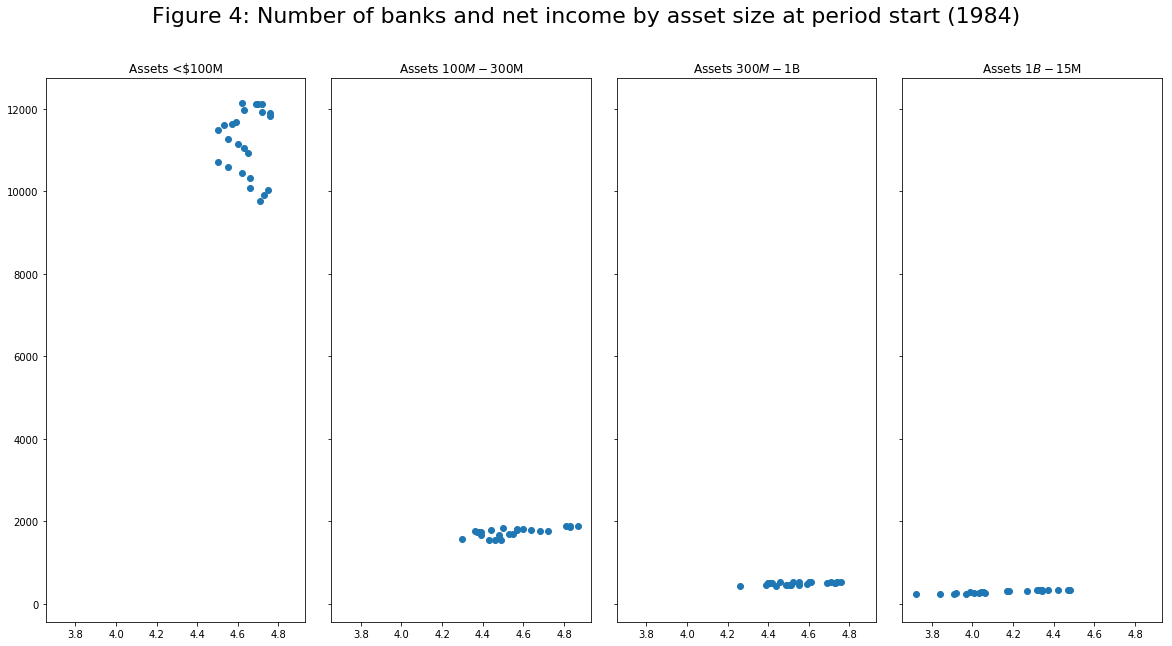

In [20]:
#Look at net income ratio in all 4 peer groups at the begining of period
fig, axs = plt.subplots(1, 4, figsize = (20,10), sharey = 'row', sharex = 'row', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle('Figure 4: Number of banks and net income by asset size at period start (1984)', fontsize = 22)
(ax1, ax2, ax3, ax4) = axs
ax1.scatter(y = df.US100NUM.iloc[0:24], x = df.US100NIM.iloc[0:24])
ax1.set_title('Assets <$100M')
ax2.scatter(y = df.US13NUM.iloc[0:24], x = df.US13NIM.iloc[0:24])
ax2.set_title('Assets $100M-$300M')
ax3.scatter(y = df.US31NUM.iloc[0:24], x = df.US31NIM.iloc[0:24])
ax3.set_title('Assets $300M-$1B')
ax4.scatter(y = df.US115NUM.iloc[0:24], x = df.US115NIM.iloc[0:24])
ax4.set_title('Assets $1B-$15M')
plt.show()

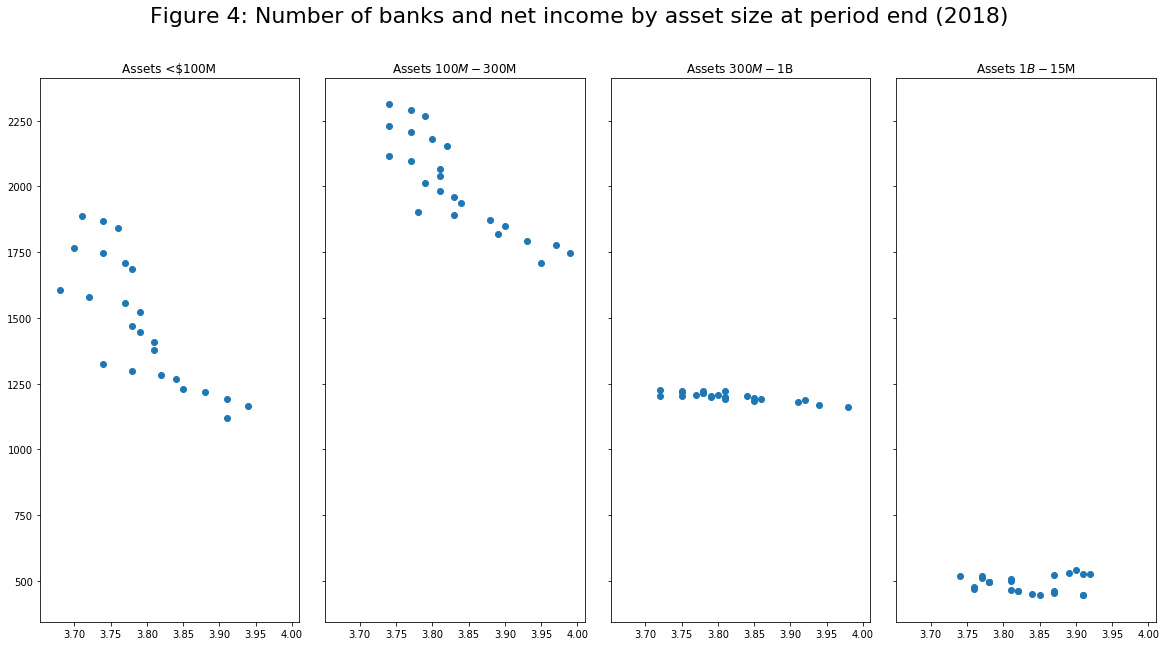

In [19]:
#Look at net income ratio in all 4 peer groups at the end of period
fig, axs = plt.subplots(1, 4, figsize = (20,10), sharey = 'row', sharex = 'row', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.suptitle('Figure 4: Number of banks and net income by asset size at period end (2018)', fontsize = 22)
(ax1, ax2, ax3, ax4) = axs
ax1.scatter(y = df.US100NUM.iloc[117:141], x = df.US100NIM.iloc[117:141])
ax1.set_title('Assets <$100M')
ax2.scatter(y = df.US13NUM.iloc[117:141], x = df.US13NIM.iloc[117:141])
ax2.set_title('Assets $100M-$300M')
ax3.scatter(y = df.US31NUM.iloc[117:141], x = df.US31NIM.iloc[117:141])
ax3.set_title('Assets $300M-$1B')
ax4.scatter(y = df.US115NUM.iloc[117:141], x = df.US115NIM.iloc[117:141])
ax4.set_title('Assets $1B-$15M')
plt.show()

## Findings: even after peer groups split, net income does not seem to be a good predictor

# Explore if Number of banks can be predicted by Total Assets (TAST)

In [21]:
#Consider alt regression of form NUM = b_0+b_1(USTATS)
#Run model for the first 24 qaurters - start of the period 
y_start = df.BanksNum.iloc[0:24]
x_start = df.USTAST.iloc[0:24]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               BanksNum   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     126.3
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           1.39e-10
Time:                        18:37:49   Log-Likelihood:                -165.61
No. Observations:                  24   AIC:                             335.2
Df Residuals:                      22   BIC:                             337.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.97e+04    530.973     37.111      0.0

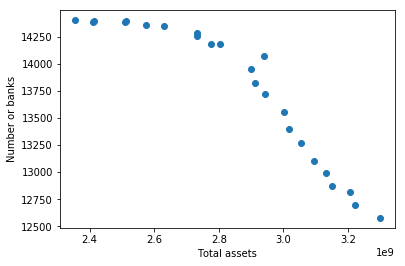

In [28]:
#Check scatter plot for linearity
plt.scatter(y=y_start, x=x_start)
plt.ylabel('Number or banks')
plt.xlabel('Total assets')
plt.show()


In [24]:
#Re-run model for the last 24 qaurters - end of the period 
y_end = df.BanksNum.iloc[117:141]
x_end = df.USTAST.iloc[117:141]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               BanksNum   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     126.3
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           1.39e-10
Time:                        18:40:13   Log-Likelihood:                -165.61
No. Observations:                  24   AIC:                             335.2
Df Residuals:                      22   BIC:                             337.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.97e+04    530.973     37.111      0.0

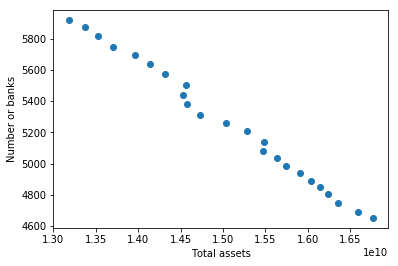

In [29]:
#Check scatter plot for linearity
plt.scatter(y=y_end, x=x_end)
plt.ylabel('Number or banks')
plt.xlabel('Total assets')
plt.show()

## Findings: better shape, but Durbin-Watson is still off

# Explore if Number of banks can be predicted by Total Assets (TAST) and Non-Performing Loans (NP)

In [30]:
#Regression of form NUM = b_0+b_1(USTATS)+b_2(NP)
#Run model for the first 24 qaurters - start of the period 

y_start = df.BanksNum.iloc[0:24]
x_start = df[['USNP', 'USTAST']].iloc[0:24]
#X = df_adv[['TV', 'Radio']]
#x_start = df.USTAST.iloc[0:24]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               BanksNum   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     60.43
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           1.94e-09
Time:                        18:49:22   Log-Likelihood:                -165.58
No. Observations:                  24   AIC:                             337.2
Df Residuals:                      21   BIC:                             340.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.966e+04    582.806     33.733      0.0

In [31]:
#Regression of form NUM = b_0+b_1(USTATS)+b_2(NP)
#re-run model for the last 24 qaurters - end of the period 

y_start = df.BanksNum.iloc[117:141]
x_start = df[['USNP', 'USTAST']].iloc[117:141]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               BanksNum   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1603.
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           1.10e-23
Time:                        18:49:49   Log-Likelihood:                -116.78
No. Observations:                  24   AIC:                             239.6
Df Residuals:                      21   BIC:                             243.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.063e+04    426.780     24.904      0.0

## Findings: p-values are too high for Non-Performing Loans

# Consider adding additional variables, such as Returns on Assest, Equity, Loan Loss Reserves together with Non-Performing Loans

In [45]:
#Run extended model for the period start
y_start = df.US100NIM.iloc[0:24]
x_start = df[['US100ROA', 'US100ROE', 'US100LLRTL', 'US100NPTL']].iloc[0:24]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               US100NIM   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     6.590
Date:                Wed, 31 Jul 2019   Prob (F-statistic):            0.00168
Time:                        19:06:42   Log-Likelihood:                 37.199
No. Observations:                  24   AIC:                            -64.40
Df Residuals:                      19   BIC:                            -58.51
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2453      0.255     20.558      0.0

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [46]:
#Re-run extended model for the period end
y_start = df.US100NIM.iloc[117:141]
x_start = df[['US100ROA', 'US100ROE', 'US100LLRTL', 'US100NPTL']].iloc[117:141]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())



                            OLS Regression Results                            
Dep. Variable:               US100NIM   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     15.26
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           9.60e-06
Time:                        19:07:46   Log-Likelihood:                 48.042
No. Observations:                  24   AIC:                            -86.08
Df Residuals:                      19   BIC:                            -80.19
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4632      0.782      5.710      0.0

In [48]:
#Check id roping variables really helps with p-values and if Durbin-Watson still stays above 1
#First, period start
y_start = df.US100NIM.iloc[0:24]
x_start = df[['US100ROA', 'US100NPTL']].iloc[0:24]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               US100NIM   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     6.150
Date:                Wed, 31 Jul 2019   Prob (F-statistic):            0.00790
Time:                        19:09:41   Log-Likelihood:                 32.290
No. Observations:                  24   AIC:                            -58.58
Df Residuals:                      21   BIC:                            -55.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6716      0.139     33.521      0.0

In [49]:
#Second, period end
y_start = df.US100NIM.iloc[117:141]
x_start = df[['US100ROA', 'US100NPTL']].iloc[117:141]
mod = sm.OLS(y_start, sm.add_constant(x_start))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               US100NIM   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     26.29
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           1.91e-06
Time:                        19:10:13   Log-Likelihood:                 45.832
No. Observations:                  24   AIC:                            -85.66
Df Residuals:                      21   BIC:                            -82.13
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2042      0.207     15.494      0.0

## Bingo! Dropping variables helps - Net Income can be predicted from ROA and NPLs

# One more check with Ridge and Lasso

In [51]:
#Penalized estimation -- variable selection with Ridge and Lasso algorithm
#First, run Small banks number on all the features
y = df.SmallBanksNum
x = df[['US100NIM', 'US13NIM', 'US31NIM', 'US115NIM', 'US100ROA',
       'US13ROA', 'US31ROA', 'US115ROA', 'US100ROE', 'US13ROE',
       'US31ROE', 'US115ROE', 'US100LLRTL', 'US13LLRTL',
       'US31LLRTL', 'US115LLRTL', 'US100NPTL', 'US13NPTL',
       'US31NPTL', 'US115NPTL']]
# Perform test train split
X_train , X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12)
# Build a Ridge, Lasso and regular linear regression model. 
# Note how in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
print('Ridge parameter coefficients:', ridge.coef_)
print('Training r^2:', ridge.score(X_train, y_train))
print('Testing r^2:', ridge.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, ridge.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, ridge.predict(X_test)))
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
print('Lasso parameter coefficients:', lasso.coef_)
print('Training r^2:', lasso.score(X_train, y_train))
print('Testing r^2:', lasso.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lasso.predict(X_test)))

Ridge parameter coefficients: [-0.03275357 -0.01464955 -0.04764989 -0.02116696  0.0609239   0.04857894
  0.07731985  0.06047817 -0.00546644 -0.01568078 -0.00120516 -0.00450359
 -0.01706243  0.04682428  0.02525194  0.0020609  -0.04304604  0.00545292
  0.03868115 -0.02636354]
Training r^2: 0.9872221703447474
Testing r^2: 0.9726438557086272
Training MSE: 0.0001037022207460091
Testing MSE: 0.00029262968351826123
Lasso parameter coefficients: [-0.         -0.         -0.         -0.         -0.         -0.
  0.          0.         -0.00965202 -0.         -0.         -0.
  0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.        ]
Training r^2: 0.3245168726875955
Testing r^2: 0.0794844482073205
Training MSE: 0.005482081250782666
Testing MSE: 0.009846788777162566


In [52]:
#Second, run Small bank number on small bank features only
y = df.SmallBanksNum
x = df[['US100NIM', 'US100ROA', 'US100ROE', 'US100LLRTL', 'US100NPTL']]
# Perform test train split
X_train , X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12) 
# Note how in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
print('Ridge parameter coefficients:', ridge.coef_)
print('Training r^2:', ridge.score(X_train, y_train))
print('Testing r^2:', ridge.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, ridge.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, ridge.predict(X_test)))
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
print('Lasso parameter coefficients:', lasso.coef_)
print('Training r^2:', lasso.score(X_train, y_train))
print('Testing r^2:', lasso.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lasso.predict(X_test)))

Ridge parameter coefficients: [-0.12505165  0.22573377 -0.03018296  0.0744907  -0.03678268]
Training r^2: 0.9561552215149846
Testing r^2: 0.890746063803487
Training MSE: 0.00035583514725787976
Testing MSE: 0.0011686933813400183
Lasso parameter coefficients: [-0.         -0.         -0.00965202  0.         -0.        ]
Training r^2: 0.3245168726875955
Testing r^2: 0.0794844482073205
Training MSE: 0.005482081250782666
Testing MSE: 0.009846788777162566


In [54]:
 #Requirements:
'''
## The Deliverables
The goal of this project is to have you complete a very common real-world task in regard to Regression and Time-Series Modeling. However, real world problems often come with a significant degree of ambiguity, which requires you to use your knowledge of statistics and data science to think critically about and answer.
In short, to pass this project, demonstrating the quality and thoughtfulness of your overall recommendation is at least as important as successfully building your models!
In order to successfully complete this project, you must have:
* A well-documented **_Jupyter Notebook_** containing any code you've written for this project.
* An **_'Executive Summary' PowerPoint Presentation_** that explains your rationale and methodology for determining the best zipcodes for investment.
### Jupyter Notebook Must-Haves
1. You must source & clean your data.  All boring stuff should be pushed to a .py file that is imported.  A single data set (albeit possibly from multiple sources) should be able to support all of the following requirements.
2. You must do one each of a linear regression, a logistic regression, and a time-series analysis (to included, at a minimum, a calculation of trend and seasonality).
3. In either your linear or logistic regression, use $R^2$ and AIC/BIC to determine the best of two models
4. Visualizations to support each of your models built
#### Organization/Code Cleanliness
The notebook should be well organized, easy to follow, and code is modularized and commented where appropriate.
* Level Up: The notebook contains well-formatted, professional looking markdown cells explaining any substantial code. All functions have docstrings that act as professional-quality documentation.
* The notebook is written to technical audiences with a way to both understand your approach and reproduce your results. The target audience for this deliverable is other data scientists looking to validate your findings.
* Data visualizations you create should be clearly labeled and contextualized--that is, they fit with the surrounding code or problems you're trying to solve. No dropping data visualizations randomly around your notebook without any context!
#### Findings
Your notebook should briefly mention the metrics you have defined as "best", so that any readers understand what technical metrics you are trying to optimize. You do **not** need to explain or defend your your choices in the notebook--the blog post and executive summary presentation are both better suited to that sort of content. However, the notebook should provide enough context about your definition for "best investment" so that they understand what the code you are writing is trying to solve.
#### Visualizations
Regression & Time-Series Analysis are areas of data science that lend themselves well to intuitive data visualizations. **_Any findings worth mentioning in this problem are probably also worth visualizing_**. Your notebook should make use of data visualizations as appropriate to make your findings obvious to any readers.
Also, remember that if a visualization is worth creating, then it's also worth taking the extra few minutes to make sure that it is easily understandable and well-formatted. When creating visualizations, make sure that they have:
* A title
* Clearly labeled X and Y axes, with appropriate scale for each
* A legend, when necessary
* No overlapping text that makes it hard to read
* An intelligent use of color--multiple lines should have different colors and/or symbols to make them easily differentiable to the eye
* An appropriate amount of information--avoid creating graphs that are "too busy"--for instance, don't create a line graph with 25 different lines on it
<center><img src='images/bad-graph-1.png' height=100% width=100%>
There's just too much going on in this graph for it to be readable--don't make the same mistake! (<a href='http://genywealth.com/wp-content/uploads/2010/03/line-graph.php_.png'>Source</a>)</center>
### Executive Summary Must-Haves
Your presentation should:
Contain between 5-10 professional quality slides detailing:
* A high-level overview of your methodology and findings, including the 5 zipcodes you recommend investing in
* A brief explanation of what metrics you defined as "best" in order complete this project
As always, this presentation should also:
* Take no more than 5 minutes to present
* Avoid technical jargon and explain results in a clear, actionable way for non-technical audiences.
'''

'\n## The Deliverables\nThe goal of this project is to have you complete a very common real-world task in regard to Regression and Time-Series Modeling. However, real world problems often come with a significant degree of ambiguity, which requires you to use your knowledge of statistics and data science to think critically about and answer.\nIn short, to pass this project, demonstrating the quality and thoughtfulness of your overall recommendation is at least as important as successfully building your models!\nIn order to successfully complete this project, you must have:\n* A well-documented **_Jupyter Notebook_** containing any code you\'ve written for this project.\n* An **_\'Executive Summary\' PowerPoint Presentation_** that explains your rationale and methodology for determining the best zipcodes for investment.\n### Jupyter Notebook Must-Haves\n1. You must source & clean your data.  All boring stuff should be pushed to a .py file that is imported.  A single data set (albeit poss